# Spearman correlation
AIDS: Dados provenientes de http://www2.aids.gov.br/cgi/deftohtm.exe?tabnet/sp.def

TUBERCULOSE: Dados provenientes de http://tabnet.datasus.gov.br (cabeçalhos adaptados)

ONCOLOGIA: http://tabnet.datasus.gov.br/cgi/webtabx.exe?PAINEL_ONCO/PAINEL_ONCOLOGIABR.def

VIOLENCIA: http://tabnet.datasus.gov.br/cgi/deftohtm.exe?sinannet/cnv/violebr.def


Import libraries

In [3]:
import pandas as pd
import glob
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
    

Read suicide csv

In [4]:
suicide = pd.read_csv('../Suicide/CSV/suicide_rate_codmunres.csv', sep=',')

Read disease files

In [5]:
year = "2017"
disease = ""
all_files = glob.glob("CSV/Rates/*.csv")

diseases_list = []
corrs_list = []
p_value_list = []
sizes_list = []
path = 'CSV/Rates/'
for file in all_files:
    file_name = file.split("\\")[1]
    disease = file_name.split("BR")[0]
    disease_df = pd.read_csv(path + disease + 'BR' + year + '_RATE.csv', sep=',')
    disease_df = disease_df[["QUANTIDADE_RATE", "MUNCOD"]]
    
    # Merge Files
    result_df = pd.merge(disease_df, suicide, left_on="MUNCOD", right_on="CODMUNRES", how="inner")
    result_df = result_df[["QUANTIDADE_RATE", "SUICIDE_RATE"]]
    
    # Spearman correlation
    file_array = result_df.iloc[:,0].values
    suicides_array = result_df.iloc[:,1].values
    corr, p_value = spearmanr(file_array,suicides_array)
    
    # Append correlation
    sizes_list.append(result_df.shape[0])
    diseases_list.append(disease)
    corrs_list.append(corr)
    p_value_list.append(p_value)

Spearman correlations table

In [6]:
corrs_data = {'Doenças': diseases_list, 'Correlação com suicidio': corrs_list, 'P value': p_value_list, 'Número de municípios': sizes_list}
corrs_df = pd.DataFrame(data=corrs_data)
corrs_df

,Doenças,Correlação com suicidio,P value,Número de municípios
0,AIDS,0.181625,1.826353e-12,1483
1,AIDS_SINAN,0.142361,5.867226e-11,2096
2,ASMA,0.202740,2.203718e-25,2585
3,CANCER_PAINEL,0.265570,1.055121e-50,3069
4,CARDIACA,0.200876,1.743483e-29,3089
5,DENGUE,0.108056,2.831428e-07,2247
6,DIABETES,0.207459,1.743129e-31,3100
7,DORSOPATIA,0.391941,4.690499e-67,1797
8,DPOC,0.345793,6.700904e-83,2924
9,ENXAQUECA,0.323917,1.591717e-33,1316


Table with diseases and suicide numbers merged per city

In [8]:
all_diseases = suicide[["SUICIDE_RATE", "CODMUNRES"]]
for file in all_files:
    file_name = file.split("\\")[1]
    disease = file_name.split("BR")[0]
    disease_df = pd.read_csv(path + disease + 'BR' + year + '_RATE.csv', sep=',')
    disease_df = disease_df[["QUANTIDADE_RATE", "MUNCOD"]]
    disease_df.rename(columns={"QUANTIDADE_RATE": disease}, inplace=True)

    # Merge with current dataframe
    all_diseases = pd.merge(disease_df, all_diseases, left_on="MUNCOD", right_on="CODMUNRES", how="inner")
    all_diseases.drop('MUNCOD', axis=1, inplace=True)
# Add SUICIDES to columns
all_diseases

,TUBERCULOSE,TRAUMATISMO,RENAL,PARKINSON,OSTEOPOROSE,OLHO,MENTAL,HIPERTENSAO,GRAVIDEZ,ESCLEROSE,...,DORSOPATIA,DIABETES,DENGUE,CARDIACA,CANCER_PAINEL,ASMA,AIDS_SINAN,AIDS,SUICIDE_RATE,CODMUNRES
0,26.847560,34.006909,91.281702,3.579675,1.789837,53.695119,32.217071,71.593492,1440.819030,5.369512,...,14.318698,216.570314,246.997548,85.912191,46.535770,37.586583,17.898373,10.739024,8.949187,110011
1,23.652466,118.262332,84.097658,5.256104,15.768311,36.792726,15.768311,270.689338,1889.569262,2.628052,...,52.561037,530.866469,115.634280,173.451420,81.469607,52.561037,10.512207,2.628052,13.140259,110018
2,92.600436,46.011443,18.289067,0.192516,34.652970,145.542473,87.980040,3.272780,1693.952672,0.577549,...,5.197945,47.166542,61.027730,48.514158,84.899776,15.593836,42.161113,72.963753,6.160528,110020
3,128.340900,31.451501,34.455823,0.187770,1.079678,32.061754,28.541063,16.805429,1844.137628,0.516368,...,1.173563,86.937581,117.403289,65.437899,74.497809,29.620742,44.454584,57.786265,4.177886,130260
4,46.047890,68.070794,37.038520,1.001041,2.002082,3.003123,56.058301,13.013534,2517.618323,1.001041,...,16.016657,124.129094,6.006246,91.094739,10.010411,38.039561,10.010411,1.001041,6.006246,150180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,46.785097,36.718866,52.504547,0.686334,5.376283,193.774951,71.721897,3.546059,1215.039865,0.457556,...,7.320895,61.884444,111.872433,86.363688,98.145754,5.605061,28.940415,94.256529,8.007229,500270
116,39.583296,42.282157,82.315263,0.449810,20.691268,237.499775,259.540474,10.795444,1548.246640,0.899620,...,6.747153,205.563252,28.787852,125.497040,87.263175,5.847532,62.073805,1.799241,8.096583,510760
117,11.995458,47.981831,71.173049,0.533131,10.129498,163.138225,566.185604,5.597880,1252.592352,0.266566,...,9.862932,80.502850,292.689168,77.837192,122.886800,13.861418,17.859904,9.862932,6.664143,520110
118,19.030015,42.561754,39.560604,0.204624,21.008045,75.301564,184.911722,5.047387,807.172747,1.773406,...,4.842764,44.335160,2075.431159,71.345504,91.466846,19.098223,21.690125,33.762930,6.616170,520870


Heatmap of the diseases and suicide

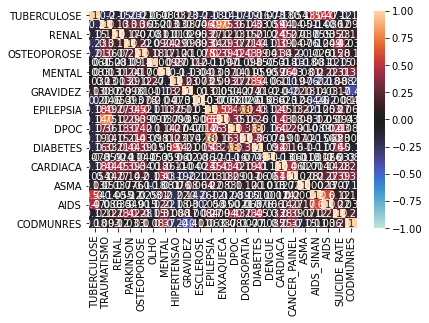

In [9]:
sns.heatmap(all_diseases.corr(), annot=True, vmin=-1, vmax=1, center=0)

## Scatter Plot
Scatter plot to visualize relationship between suicide and hospital adminissions for mental conditions

Load file

In [10]:
disease_df = pd.read_csv('CSV/Quantity/MENTALBR2017.csv', sep=',')
suicide_df = pd.read_csv('../Suicide/CSV/suicides_codmunres.csv')

Merge files

In [11]:
result = pd.merge(disease_df, suicide_df, left_on="MUNCOD", right_on="CODMUNRES", how="inner")
result = result[["QUANTIDADE", "SUICIDES"]]

Plot

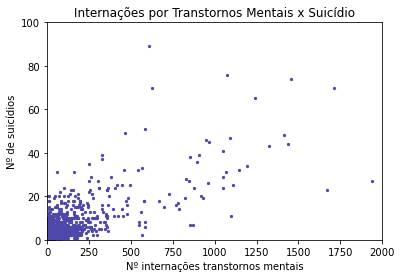

In [12]:
plt.scatter(result["QUANTIDADE"], result["SUICIDES"], s=5, color='#4e48ab')
plt.xlabel("Nº internações transtornos mentais")
plt.ylabel("Nº de suicídios")
plt.title("Internações por Transtornos Mentais x Suicídio")
axes = plt.gca()
axes.set_xlim([0,2000])
axes.set_ylim([0,100])
plt.style.use('dark_background')
plt.rcParams['axes.facecolor'] = '#f8fafb'
plt.rcParams['savefig.facecolor'] = '#33364f'
